In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, 'code/')

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchsummaryX import summary

from tqdm import tqdm_notebook as tqdm

from mac import MACNetwork
from utils import load_vocab
from datasets import ClevrDataset, collate_fn, QOnlyDataset, qonly_collate_fn

In [6]:
from config import cfg_from_file, __C, cfg

cfg_from_file('cfg/local.yml')
__C.CUDA = False
__C.GPU_ID = '-1'
vocab = load_vocab(cfg)
# cfg.TRAIN.RECV_OBJECTS = False

In [7]:
model = MACNetwork(cfg=cfg, max_step=4, vocab=vocab)
model.load_state_dict(torch.load('/Users/sebamenabar/Documents/concept_mac_transform.pth', map_location='cpu')['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
def forward_q(model, question, question_len):
    embed = model.input_unit.encoder_embed(question)
    embed = model.input_unit.embedding_dropout(embed)
    embed = nn.utils.rnn.pack_padded_sequence(embed, question_len, batch_first=True)

    contextual_words, (question_embedding, _) = model.input_unit.encoder(embed)
    if model.input_unit.bidirectional:
        question_embedding = torch.cat([question_embedding[0], question_embedding[1]], -1)
    question_embedding = model.input_unit.question_dropout(question_embedding)

    contextual_words, _ = nn.utils.rnn.pad_packed_sequence(contextual_words, batch_first=True)
    
    return question_embedding, contextual_words

def get_category_attention(model, cws):
    return model.mac.control.concept_memory.get_category_attention(cws.contiguous().view(-1, 512))

def get_both(model, question, question_len):
    _, cws = forward_q(model, question, question_len)
    cattention = get_category_attention(model, cws)
        
    return cws, cattention.view(cws.size(0), cws.size(1), -1)

In [9]:
ds = QOnlyDataset(
    data_dir='/Users/sebamenabar/Documents/datasets/CLEVR/data',
    # img_dir='/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/',
    # scenes_json='/Users/sebamenabar/Documents/TAIA/individual/sm/data/clevr/train/scenes.json',
    # raw_image=True,
    split='val',
)

In [10]:
loader = DataLoader(dataset=ds, batch_size=10, shuffle=True,
                                       num_workers=2, drop_last=False, collate_fn=qonly_collate_fn)

In [12]:
def idxs_to_q(questions, vocab):
    return [
        ' '.join([
            vocab[idx.item()] for idx in question if idx.item() !=0
        ]) for question in questions
    ]

In [11]:
vocab.keys()

dict_keys(['question_token_to_idx', 'answer_token_to_idx', 'question_idx_to_token', 'answer_idx_to_token'])

In [14]:
colors = ['gray', 'red', 'blue', 'green', 'brown', 'purple', 'cyan', 'yellow']
sizes = ['large', 'small']
shapes = ['cube', 'sphere', 'cylinder']
material = ['rubber', 'metal']

atts_dict = dict(colors=colors, sizes=sizes, shapes=shapes, material=material)
all_atts = [*colors, *sizes, *shapes, *material]

In [13]:
res = {
    idx: {
        'cws': torch.FloatTensor(0, 512),
        'category': torch.FloatTensor(0, 4),
    } for idx in vocab['question_idx_to_token'].keys()
}

model.eval()
for i, b in tqdm(enumerate(loader), total=len(loader)):
    with torch.no_grad():
        contextual_words, cattention = get_both(model, b['question'], b['question_length'])
        for idx, cw, cat in zip(
            b['question'].contiguous().view(-1),
            contextual_words.contiguous().view(-1, 512),
            cattention.contiguous().view(-1, 4),
        ):
            res[idx.item()]['cws'] = torch.cat((res[idx.item()]['cws'], cw.unsqueeze(0)))
            res[idx.item()]['category'] = torch.cat((res[idx.item()]['category'], cat.unsqueeze(0)))
            
            # print(idxs_to_q(b['question'], vocab['question_idx_to_token']))
        
    if i >= 50:
        break
        
for att_name in all_atts:
    print(att_name, res[vocab['question_token_to_idx'][att_name]]['category'].size(0))

NameError: name 'all_atts' is not defined

In [15]:
for att_name in all_atts:
    print(att_name, res[vocab['question_token_to_idx'][att_name]]['category'].size(0))

gray 75
red 85
blue 90
green 71
brown 103
purple 94
cyan 100
yellow 67
large 127
small 149
cube 96
sphere 100
cylinder 141
rubber 140
metal 107


In [16]:
all_tensors = torch.cat([res[vocab['question_token_to_idx'][att]]['category'] for att in all_atts])

In [17]:
all_tensors.size()

torch.Size([1545, 4])

In [27]:
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(all_tensors[:, :256].numpy())

In [28]:
import matplotlib.pyplot as plt

%matplotlib notebook

from matplotlib.cm import get_cmap

get_cmap('tab20')

In [35]:
res[vocab['question_token_to_idx']['blue']]['category']

tensor([], size=(0, 4))

In [19]:
for color in colors:
    print(color, res[vocab['question_token_to_idx'][color]]['category'].mean(dim=0))

gray tensor([0.8843, 0.0117, 0.0048, 0.0991])
red tensor([0.7982, 0.0161, 0.0070, 0.1787])
blue tensor([0.8690, 0.0313, 0.0091, 0.0906])
green tensor([0.7588, 0.0303, 0.0015, 0.2094])
brown tensor([0.6707, 0.1485, 0.0015, 0.1793])
purple tensor([8.0574e-01, 1.2610e-02, 2.7587e-05, 1.8162e-01])
cyan tensor([7.2933e-01, 2.3280e-02, 7.0494e-04, 2.4669e-01])
yellow tensor([7.8602e-01, 4.2367e-02, 4.2927e-04, 1.7118e-01])


In [20]:
for att in sizes:
    print(att, res[vocab['question_token_to_idx'][att]]['category'].mean(dim=0))

large tensor([9.1671e-01, 1.6318e-04, 1.2730e-02, 7.0401e-02])
small tensor([7.5780e-01, 4.8800e-07, 6.3929e-06, 2.4219e-01])


In [21]:
for att in shapes:
    print(att, res[vocab['question_token_to_idx'][att]]['category'].mean(dim=0))

cube tensor([0.4456, 0.3875, 0.1273, 0.0395])
sphere tensor([6.4390e-01, 5.8003e-05, 8.5021e-02, 2.7102e-01])
cylinder tensor([0.7772, 0.0360, 0.1181, 0.0688])


In [22]:
for att in material:
    print(att, res[vocab['question_token_to_idx'][att]]['category'].mean(dim=0))

rubber tensor([0.1945, 0.0087, 0.1215, 0.6754])
metal tensor([0.8877, 0.0392, 0.0126, 0.0605])


In [32]:
torch.softmax(torch.FloatTensor([0, 0, 0, 1]), 0)

tensor([0.1749, 0.1749, 0.1749, 0.4754])

In [30]:
%matplotlib notebook

<IPython.core.display.Javascript object>


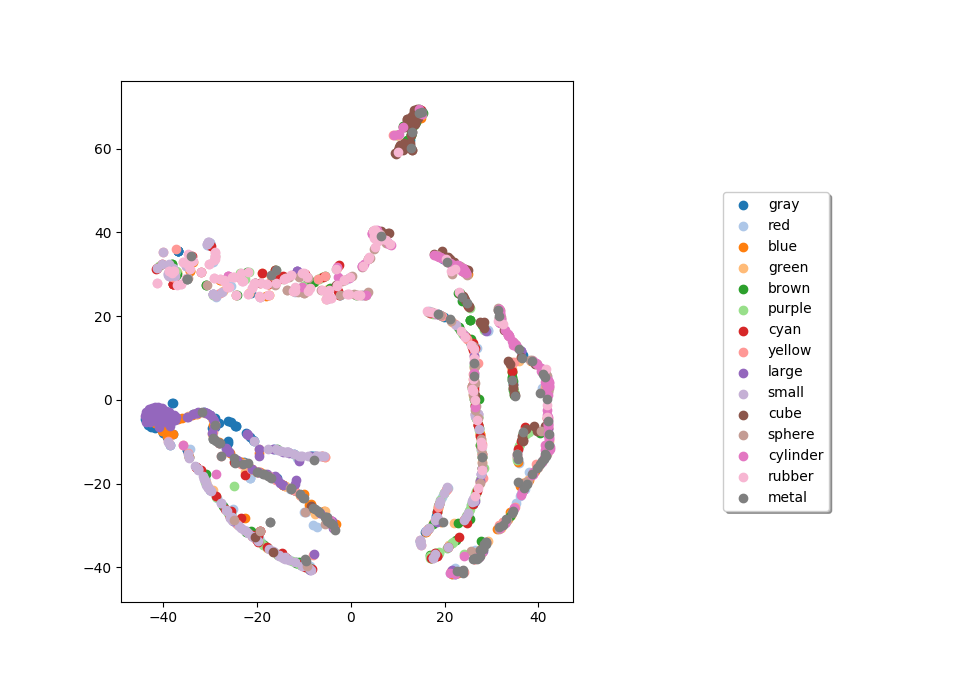

gray 75
red 85
blue 90
green 71
brown 103
purple 94
cyan 100
yellow 67
large 127
small 149
cube 96
sphere 100
cylinder 141
rubber 140
metal 107


In [31]:
cmap = get_cmap('tab20')

i = 0
j = 0

fig = plt.figure()
ax = plt.subplot(111)

for categories, attributes in atts_dict.items():
    
    for value in attributes:
        current = res[vocab['question_token_to_idx'][value]]['category'].size(0)
        print(value, current)

    
        ax.scatter(transformed[i:i + current, 0], transformed[i:i + current, 1], label=value, c=[cmap.colors[j]])
        
        # ax.scatter(x, y, label='$y = numbers')
        i = i + current
        j += 1
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), shadow=True, ncol=1)
plt.show()

# plt.legend()